# W207 Summer 2017 Final Project

## Personalized Medicine: Redefining Cancer Treatment



#### Matt Shaffer https://github.com/planetceres 
#### Kaggle Competition: https://www.kaggle.com/c/msk-redefining-cancer-treatment

According to [discussion boards](https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35810#202604) on Kaggle, the classes we are trying to predict appear to be as follows:

1. Likely Loss-of-function
2. Likely Gain-of-function
3. Neutral
4. Loss-of-function
5. Likely Neutral
6. Inconclusive
7. Gain-of-function
8. Likely Switch-of-function
9. Switch-of-function


#### Dependencies

In [1]:
import os
import time
import glob
import re
import pandas as pd
import numpy as np
import scipy.sparse as sps
import Bio

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import explained_variance_score
from sklearn.pipeline import make_pipeline

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

%matplotlib inline
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')
from itertools import islice

In [2]:
model_version = '001'

In [3]:
model_name = 'model_' + model_version

In [3]:
data_directory = '/Users/Reynard/dropbox/Data/kaggle/Personalized Medicine'
model_directory = data_directory + '/saved_models'

In [5]:
model_path = os.path.join(model_directory, model_name)

In [6]:
# Create model directory if it does not exist
if not os.path.isdir(model_directory):
    print("creating directory for saved models")
    os.mkdir(model_directory)

In [7]:
# Load model to resume training or perform inference
def load_model_from_json(model_path):
    model = model_from_json(open(model_path + '.json').read())
    model.load_weights(model_path + '.h5')
    #model.compile(optimizer=rmsprop, loss='mse')
    return model

In [8]:
from keras.models import load_model
# Load model to resume training or perform inference
def load_recent_model(model_path):
    # Locate the most recent model the folder to resume training from
    model_recent = max(glob.iglob(model_path + '*.hdf5'), key=os.path.getctime)
    print("Using model at checkpoint: {}".format(model_recent))
    #model = model_from_json(open(model_path + '.json').read())
    model = load_model(model_recent)
    #model.compile(optimizer=rmsprop, loss='mse')
    return model

In [9]:
# Save model
def save_model_to_json(m, model_path):    
    json_string = m.model.to_json()
    open(model_path + '.json', 'w').write(json_string)
    m.model.save_weights(model_path + '.h5', overwrite=True)

In [10]:
def print_op_str(data_type):
    p = "Done processing " + data_type + " data in {:.2f} seconds"
    return p

In [11]:
def print_blank(n):
    print(" "*n, end="\r")

### Data Overview

In [4]:
train_variants = pd.read_csv(data_directory + "/input/training_variants")
test_variants = pd.read_csv(data_directory + "/input/test_variants")
train_text = pd.read_csv(data_directory + "/input/training_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
test_text = pd.read_csv(data_directory + "/input/test_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])

The test set has no labels and is used only for score submission. This will be a challenge since the sample size is small, and it will be hard to learn the properties of the population needed to perform inference. 

In [5]:
# Test set has no labels and is used 
print(list(train_variants.columns))
print(list(test_variants.columns))

['ID', 'Gene', 'Variation', 'Class']
['ID', 'Gene', 'Variation']


In addition to the gene variant data, we also have a text corpus for each example that provides the clinical evidence that human experts used to classify the genetic mutations. This is essentially an unstructured feature set, and our first task will be to map this noisy data to a set of features that can more easily be used for prediction. 

In [6]:
print(list(train_text.columns))
print(list(test_text.columns))

['ID', 'Text']
['ID', 'Text']


In [7]:
# Merge the text with the variant data, and separate the target values (`Class`) from the features
train = pd.merge(train_variants, train_text, how='left', on='ID')
y_train = train['Class'].values
X_train = train.drop('Class', axis=1)

In [8]:
# Do the same thing with the test data, but note that there are no classes to separate as targets
X_test = pd.merge(test_variants, test_text, how='left', on='ID')
test_index = X_test['ID'].values

In [9]:
# Create mini data sets for model building
train_mini = train.sample(frac=0.05)
y_train_mini = train_mini['Class'].values
X_train_mini = train_mini.drop('Class', axis=1)
X_test_mini = X_test.sample(frac=0.05)
test_index_mini = X_test_mini['ID'].values

# Create mini dev set for model building
dev_mini = train.sample(frac=0.05)
y_dev_mini = dev_mini['Class'].values
X_dev_mini = dev_mini.drop('Class', axis=1)

In [10]:
X_train_mini.shape

(166, 4)

In [12]:
# create dataset with all variants
all_variants = pd.concat([train_variants, test_variants], ignore_index=True)

### TFIDF

We need some way to create learnable features out of the text, so applying a TFIDF vectorizer seems like a logical first strategy. 

In [17]:
corpus_train = X_train['Text']
corpus_test = X_test['Text']

In [15]:
corpus_train.shape

(3321,)

In [21]:
corpus_train.head()

0    Cyclin-dependent kinases (CDKs) regulate a var...
1     Abstract Background  Non-small cell lung canc...
2     Abstract Background  Non-small cell lung canc...
3    Recent evidence has demonstrated that acquired...
4    Oncogenic mutations in the monomeric Casitas B...
Name: Text, dtype: object

In [23]:
corpus_test.head()

0    2. This mutation resulted in a myeloproliferat...
1     Abstract The Large Tumor Suppressor 1 (LATS1)...
2    Vascular endothelial growth factor receptor (V...
3    Inflammatory myofibroblastic tumor (IMT) is a ...
4     Abstract Retinoblastoma is a pediatric retina...
Name: Text, dtype: object

In [17]:
corpus_test.shape

(5668,)

In [18]:
corpus_train_mini = X_train_mini['Text']
corpus_test_mini = X_test_mini['Text']
corpus_dev_mini = X_dev_mini['Text']

**Functions**

In [19]:
def sparse_metrics(transformer_type, sparse_mtx):
    print("Vocabulary length: {}".format(len(transformer_type.vocabulary_)))
    print('sparse matrix shape: {}'.format(sparse_mtx.shape))
    print('nonzero count: {}'.format(sparse_mtx.nnz))
    print('sparsity: {:.2f}'.format((100.0 * sparse_mtx.nnz / (sparse_mtx.shape[0] * sparse_mtx.shape[1]))))

In [20]:
def tfidf_func(X, Y, ngrams=1, plotting=False):
    t = time.time()
    tfidf = TfidfVectorizer(stop_words = 'english', ngram_range=(1, ngrams), sublinear_tf=True, use_idf=True)
    tfidf_train = tfidf.fit_transform(X)
    print(print_op_str("train").format(time.time()-t), end="\r")
    tfidf_test = tfidf.transform(Y)
    print(print_op_str("test").format(time.time()-t), end="\r")
    print_blank(len(print_op_str("test")))
    
    print_op = "Shape: {}\nNon-zero mean: {}\nNon-zero median: {}"
    mean_nnz = int(round(np.mean(tfidf_train.getnnz(1))))
    median_nnz = int(round(np.median(tfidf_train.getnnz(1))))
    print(print_op.format(tfidf_train.shape, mean_nnz,median_nnz))
    print("\nDone in {:.2f} seconds".format(time.time()-t))
    
    if plotting == True:     
        fig, ax = plt.subplots(figsize=(12, 6))
        plt.plot(np.sort(tfidf_train.getnnz(1))[::-1])

        # Log transformed
        plt.figure(figsize=(12,6))
        plt.plot(np.sort(np.log(tfidf_train.getnnz(1)))[::-1])
        
    return tfidf, tfidf_train, tfidf_test


In [40]:
# TFIDF on mini dataset
tf_1, tf_train_1, tf_test_1 = tfidf_func(corpus_train_mini, corpus_test_mini, ngrams=1, plotting=False)

Shape: (166, 40669)                        
Non-zero mean: 1628
Non-zero median: 1385
Done in 4.14 seconds


In [44]:
sparse_metrics(tf_1, tf_train_1)

Vocabulary length: 40669
sparse matrix shape: (166, 40669)
nonzero count: 270168
sparsity: 4.00


** Ngram == 2 **

In [119]:
tfidf = TfidfVectorizer(stop_words = 'english', ngram_range=(1, 2), sublinear_tf=True, use_idf=True)
tfidf_train = tfidf.fit_transform(corpus_train)
tfidf_test = tfidf.transform(corpus_test)

In [120]:
print("Shape: {}\nNon-zero mean: {}\nNon-zero median: {}".format(tfidf_train.shape, 
                                                                 int(round(np.mean(tfidf_train.getnnz(1)))),
                                                                 int(round(np.median(tfidf_train.getnnz(1))))))

Shape: (3321, 2887033)
Non-zero mean: 6015
Non-zero median: 4555


In [121]:
# Non zero values for first entry in training set
tfidf_train[0].nnz

4240

Plot non-zero values

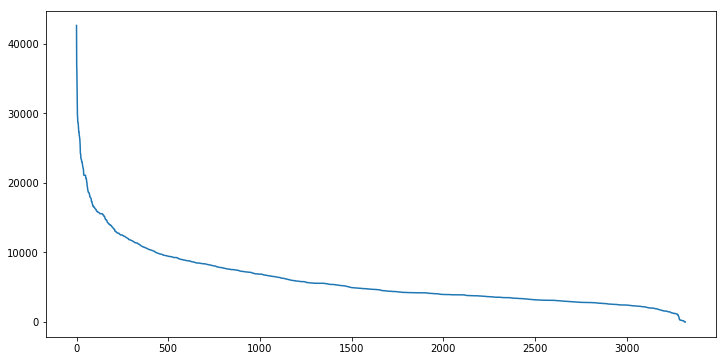

In [122]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(np.sort(tfidf_train.getnnz(1))[::-1])

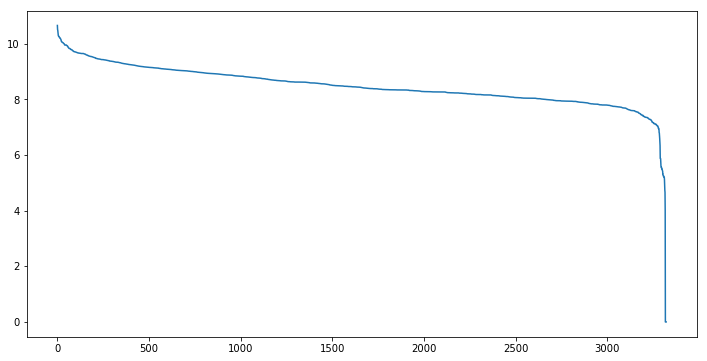

In [123]:
# Log transformed
plt.figure(figsize=(12,6))
plt.plot(np.sort(np.log(tfidf_train.getnnz(1)))[::-1])

In [124]:
np.sort(np.array(tfidf_train.sum(axis=0))[0])[::-1][:10]

array([ 193.55342793,  138.98355951,  121.01724619,   98.93547919,
         91.42839175,   85.64171263,   84.84211607,   84.70932757,
         84.5755022 ,   84.44620146])

In [125]:
np.argmax(np.array(tfidf_train.sum(axis=0))[0])

1814889

The top words overall that contribute to TF-IDF scores for the training set:

In [128]:
top_features = np.argsort(np.array(tfidf_train.sum(axis=0))[0])[::-1][:200]
for i, idx in enumerate(top_features):
    print("[{}] {}".format(i+1, tfidf.get_feature_names()[idx]), end=" "*2)

[1] mutations  [2] brca1  [3] cells  [4] variants  [5] fig  [6] mutation  [7] al  [8] cell  [9] et al  [10] et  [11] cancer  [12] pten  [13] egfr  [14] figure  [15] patients  [16] p53  [17] protein  [18] activity  [19] kinase  [20] mutant  [21] tumor  [22] type  [23] domain  [24] mutants  [25] expression  [26] brct  [27] binding  [28] vus  [29] ras  [30] alk  [31] data  [32] using  [33] wild  [34] tumors  [35] wild type  [36] analysis  [37] gene  [38] dna  [39] table  [40] raf  [41] deleterious  [42] supplementary  [43] 10  [44] activation  [45] braf  [46] exon  [47] imatinib  [48] variant  [49] kit  [50] brca2  [51] resistance  [52] pdgfra  [53] functional  [54] results  [55] genes  [56] function  [57] associated  [58] tsc2  [59] missense  [60] flt3  [61] wt  [62] identified  [63] clinical  [64] used  [65] growth  [66] shown  [67] signaling  [68] proteins  [69] human  [70] residues  [71] akt  [72] mtor  [73] assay  [74] study  [75] breast  [76] neutral  [77] assays  [78] phosphorylati

The words that contribute least overall to TF-IDF scores for the training set are listed below. Many of these appear to be words with citations following them, such as `identified16`, `treatments6`, `tumours18`, `immunological26`, etc. Unfortunately, this presents a challenge because some of the genes also end with numbers(such as `RUNX1`, `BRCA2`), which means we can't just truncate the words. We also see things like gene sequences (i.e. `aagggaccagtacag`) and measurements (`333nm`, `200µg`) that likely refer to results discussed in specific papers. These might be relevant in very specific context, but probably won't help generalize predictions during inference.

In [ ]:
bottom_features = np.argsort(np.array(tfidf_train.sum(axis=0))[0])[::-1][-200:-1]
for i, idx in enumerate(bottom_features):
    print("[{}] {}".format(i+1, tfidf.get_feature_names()[idx]), end=" "*2)

In [ ]:
plt.plot(np.sort(np.array(np.log(tfidf_train.sum(axis=0)))[0])[::-1][:1000])

In [ ]:
#tfidf_train[0,1]
pd.DataFrame(tfidf_train.sum(axis=0))

In [ ]:
pd.DataFrame(tfidf_train.sum(axis=0)).hist()

##  Text Data Preprocessing

Create list of unique `Gene` and `Variation` values that are in the training and test sets. This will be used for text preprocessing.

In [21]:
corpus_obj = [
    X_train['Gene'],
    X_train['Variation'],
    X_test['Gene'],
    X_test['Variation']
]

tt_corpus = []
[tt_corpus.extend(df.values.tolist()) for df in corpus_obj]
tt_corpus = pd.Series(tt_corpus)
tt_corpus = [s.lower() for s in list(tt_corpus.unique())]
len(tt_corpus)

10116

We would like to correct our text for tokens that appear as different due to text formatting of things like citations. Ideally, we would compare our features to a dictionary list that contains common terms for the domain of genomics research. Using just the list created from the `Gene` and ` Variation` data, we are at risk of missing important tokens that might be related, or not in the observations.

One example, is `p16ink4a`, which was one of the highest predictors for tfidf, but does not appear in our list of terms. 

In [46]:
str_x = "p16ink4a"
if str_x.lower() not in tt_corpus:
    str_x = re.sub(r'^[^a-zA-z]*|[^a-zA-Z]*$', "", str_x, 0)
str_x

'p16ink4a'

In [183]:
cv_gene = CountVectorizer(lowercase=True, ngram_range=(1,1))
cv_gene.fit(tt_corpus)
list(islice(cv_gene.vocabulary_.items(), 20))

[('l155h', 4413),
 ('pkhd1', 6115),
 ('y570h', 9994),
 ('nipa1', 5536),
 ('s1297del', 7950),
 ('r299h', 7058),
 ('r216c', 6832),
 ('r108l', 6441),
 ('chst3', 1119),
 ('y514c', 9977),
 ('bbs9', 662),
 ('y599_d600inseyeyeyey', 10002),
 ('t14p', 8627),
 ('w372s', 9647),
 ('cyp21a2', 1193),
 ('s199c', 8047),
 ('y374c', 9923),
 ('t599_v600insv', 8882),
 ('y568_l576delinsvn', 9993),
 ('r69c', 7610)]

** Custom Preprocessing**

In [22]:
sw = stopwords
stopwrds = sw.words('english')

In [23]:
def text_preprocessor(s, action=1):
    
    # lowercase (this is already defaulted in Count Vectorizer)
    s = s.lower()
    
    # Regex functions
    def regexer(s, keep=None):
        
        # remove numbers at end of words that might be citations or other misleading modifiers
        if keep == "no_citations":
            if s.lower() not in tt_corpus:
                regex = r"^[^a-zA-z]*|[^a-zA-Z]*$"
                
        # remove all numbers in words that might be citations or other misleading modifiers
        if keep == "no_numbers":
            if s.lower() not in tt_corpus:
                regex = r"[^a-zA-Z ]"
            
        # Apply Regex transformation
        s = re.sub(regex, "", s, 0)
        return s
    
    # Remove stop words
    def stopwords(s):
        
        # Use nltk function for tokenization
        tokens = word_tokenize(s) 
        
        # Get stopwords list from nltk.corpus and remove words in the list
        s_bin = [w for w in tokens if not w in stopwrds]
        s = ' '.join(s_bin)
        return s
    
    # Lemmatize or stem function
    def lemmatize(s, func="stem"):
        # Split string into individual tokens
        tokens = word_tokenize(s) 
        s_bin = []
        
        # Stem tokens
        if func == "stem":
            fn = PorterStemmer().stem
        # Lemmatization
        if func == "lemma":
            fn = WordNetLemmatizer().lemmatize
        
        for t in tokens:
            s_bin.append(fn(t))
        s = ' '.join(s_bin)
        return s
    
    # Select transformation based on `action` parameter
    if 0 in action:
        s = regexer(s, keep="no_citations")
    if 1 in action:
        s = regexer(s, keep="no_numbers")
    if 2 in action:
        s = stopwords(s)
    if 3 in action:
        s = lemmatize(s, "lemma")
    if 4 in action:
        s = lemmatize(s, "stem")

    return s

In [201]:
cv = CountVectorizer(preprocessor=lambda x: text_preprocessor(x, action=[0, 2, 3]), 
                     lowercase=True, 
                     stop_words='english', 
                     min_df=1, 
                     max_df=.1, 
                     ngram_range=(1,2))
cv

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.1, max_features=None, min_df=1,
        ngram_range=(1, 2),
        preprocessor=<function <lambda> at 0x14cd481e0>,
        stop_words='english', strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)

In [204]:
cv_train_mini = cv.fit_transform(corpus_train_mini)
cv_dev_mini = cv.transform(corpus_dev_mini)

In [22]:
train_cv = cv.fit_transform(corpus_train)

In [23]:
test_cv = cv.transform(corpus_test)

Some sample bigrams from the count vectorizer show terms that intuitively seem to be relevant to determining the class of gene-variant pairings. For example, `methylation mutational` describes the process of methylation, which regulates gene expression, and the pairing with `mutational` provides context. `resistance clinical` seems important in the context of gene pairings, as well as `site frequency`. 

In [200]:
# Sample bi-grams
list(islice(cv.vocabulary_.items(), 20))

[('128 MN1', 37587),
 ('problem genetic', 2394330),
 ('size inversely', 2649165),
 ('Invitrogen catalog', 669650),
 ('methylation mutational', 2115605),
 ('hotspot SNPs', 1850576),
 ('Endogenous MyD88', 500475),
 ('supplement 1B', 2732633),
 ('Recently NUP98', 921101),
 ('phase data', 2322665),
 ('resistance clinical', 2533397),
 ('site frequency', 2646231),
 ('underline 712', 2843950),
 ('pGBT9 TRP1', 2276264),
 ('Fgfr3 Viable', 533516),
 ('pY869 detected', 2282312),
 ('665752 JNJ38877605', 225464),
 ('Research Inc', 926139),
 ('key advance', 1985754),
 ('site Their', 2645338)]

Tri-grams might also be relevant, and there are some examples below, but due to computational limitations, using CountVectorizer or TFIDF with a range of 1-3 doesn't seem possible without moving this analysis to a cloud computing platform. Even when selecting for only 10% of the possible vocabulary, the number of features grows to over 20 million when tokenizing with `range(1,3)`.

In [29]:
# Sample tri-grams
list(islice(cv.vocabulary_.items(), 20))

[('day 43 005', 2358384),
 ('differently result combined', 2583154),
 ('man 191100 clinical', 4757053),
 ('ssa hdr', 7250466),
 ('10 dl hematocrit', 37545),
 ('medulloblastomas 68 demonstrated', 4851125),
 ('functioning different pathway', 3452747),
 ('analtech newark developed', 1070313),
 ('rasq61r control', 6362798),
 ('tumor tissue sts', 7876878),
 ('nk granulo monocytic', 5343760),
 ('block cdh1', 1433634),
 ('vivo study pk', 8146749),
 ('containing p53 dna', 2137352),
 ('deficiency promotes differentiated', 2392257),
 ('pvhl213 lysine', 6268396),
 ('project bi78d3 santa', 6135025),
 ('counted study property', 2214788),
 ('hdmec hemec transfected', 3747309),
 ('amplification 11q22 subgroup', 1054921)]

In [25]:
len(cv.vocabulary_)
print('sparse matrix shape: {}'.format(train_cv.shape))
print('nonzero count: {}'.format(train_cv.nnz))
print('sparsity: {:.2f}'.format((100.0 * train_cv.nnz / (train_cv.shape[0] * train_cv.shape[1]))))

sparse matrix shape: (3321, 2690998)
nonzero count: 15229698
sparsity: 0.17


In [30]:
len(cv.vocabulary_)
print('sparse matrix shape: {}'.format(train_cv.shape))
print('nonzero count: {}'.format(train_cv.nnz))
print('sparsity: {:.2f}'.format((100.0 * train_cv.nnz / (train_cv.shape[0] * train_cv.shape[1]))))

sparse matrix shape: (3321, 8277612)
nonzero count: 33126986
sparsity: 0.12


In [26]:
occ = np.asarray(train_cv.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': cv.get_feature_names(), 'occurrences': occ})
counts_df.sort_values(by='occurrences', ascending=False).head(20)

,occurrences,term
2645842,13532,vus
1874194,12129,pdgfra
1753241,11573,notch
2546317,11073,tsc2
1179301,11056,gist
2326362,10944,smad4
410356,10589,ar
2354408,10078,spop
1760727,9014,nrf2
2324983,8603,smad2


In [27]:
counts_df.sort_values(by='occurrences', ascending=False).tail(20)

,occurrences,term
481169,1,bgj398 patient
1844442,1,parameter malignant
827008,1,described hepatocellular
481156,1,bgj398 crc334
1249173,1,hinted egfrviii
1844460,1,parameter modulating
481144,1,bgiii sensitive
1844458,1,parameter mm
1844457,1,parameter mlh1
1844456,1,parameter minimum


In [24]:
def tfidf_fn(X, Y, ngrams=1, mn=1, mx=0.1, test_transform=False, plotting=False):
    t = time.time()
    tfidf = TfidfVectorizer(stop_words = 'english', 
                            ngram_range=(1, ngrams), 
                            sublinear_tf=True, 
                            use_idf=True, 
                            preprocessor=lambda x: text_preprocessor(x, action=[0, 2, 3]), 
                            lowercase=True, 
                            min_df=mn, 
                            max_df=mx)
    print("Beginning tf-idf on training data", end="\r")
    tfidf_train = tfidf.fit_transform(X)
    print(print_op_str("train").format(time.time()-t), end="\r")
    
    if test_transform == True:
        print("Beginning tf-idf on test data", end="\r")
        tfidf_test = tfidf.transform(Y)
        print(print_op_str("test").format(time.time()-t), end="\r")
        print_blank(len(print_op_str("test")))
    else:
        tfidf_test = sps.csr_matrix((1,1))
        print_blank(len(print_op_str("train")))
    
    print_op = "Shape: {}\nNon-zero mean: {}\nNon-zero median: {}"
    mean_nnz = int(round(np.mean(tfidf_train.getnnz(1))))
    median_nnz = int(round(np.median(tfidf_train.getnnz(1))))
    print(print_op.format(tfidf_train.shape, mean_nnz,median_nnz))
    print("\nDone in {:.2f} seconds".format(time.time()-t))
    
    if plotting == True:     
        fig, ax = plt.subplots(figsize=(12, 6))
        plt.plot(np.sort(tfidf_train.getnnz(1))[::-1])

        # Log transformed
        plt.figure(figsize=(12,6))
        plt.plot(np.sort(np.log(tfidf_train.getnnz(1)))[::-1])
        
    return tfidf, tfidf_train, tfidf_test

In [65]:
tf_mini, tf_train_mini, tf_dev_mini = tfidf_fn(corpus_train_mini, 
                                                corpus_dev_mini, 
                                                ngrams=1, 
                                                mn=1, 
                                                mx=0.1, 
                                                test_transform=True, 
                                                plotting=False)

Shape: (166, 31358)                        
Non-zero mean: 478
Non-zero median: 394

Done in 81.18 seconds


In [135]:
occ = np.asarray(tf_train_mini.sum(axis=0)).ravel().tolist()
comp_df = pd.DataFrame({'term': tf_mini.get_feature_names(), 'occurrences': occ})
comp_df.sort_values(by='occurrences', ascending=False).head(20)

,occurrences,term
34791,1.558993,vus
19955,1.315848,l858r
31120,1.314083,stat5
15606,1.272930,gist
24631,1.190774,p110α
25284,1.139664,pdgfra
30669,1.104860,smad4
7597,1.079173,brca
10394,1.026186,crizotinib
21587,1.024441,mek2


## Dimensionality Reduction

### Mini data set

In [25]:
def svd_metrics(s, n):
    explained_variance = s.explained_variance_ratio_.sum()
    #     print_op = "Explained variance of SVD with {} features: {}%"
    #     print(print_op.format(n, int(explained_variance * 100)))
    return explained_variance

In [26]:
def svd_fn(data_train, data_test=None, target=None, n_features=20, test_transform=False, plotting=False):
    t = time.time()
    print("Beginning svd on training data", end="\r")
    svd = TruncatedSVD(n_features, algorithm='arpack')
    svd_train = svd.fit_transform(data_train)
    print(print_op_str("train").format(time.time()-t), end="\r")
    
    if test_transform == True:
        print("Beginning svd on test data", end="\r")
        svd_test = svd.transform(data_test)
        print(print_op_str("test").format(time.time()-t), end="\r")
        print_blank(len(print_op_str("test")))
    else:
        svd_test = sps.csr_matrix((1,1))
        print_blank(len(print_op_str("train")))
        
    total_explained_variance = svd_metrics(svd, n_features)
        
    if plotting == True:
        data2D_svd = svd_train
        plt.scatter(data2D_svd[:,0], data2D_svd[:,1], c=target)
        plt.show()  
        
    return svd, svd_train, svd_test, total_explained_variance

In [187]:
features_n_svd = 200

In [188]:
svd_mini, svd_train_mini, svd_test_mini, tev_mini = svd_fn(tf_train_mini, 
                                                 tf_dev_mini, 
                                                 y_train_mini, 
                                                 features_n_svd, 
                                                 test_transform=False, 
                                                 plotting=False)

Explained variance of SVD with 2 features: 5%


In [95]:
Vt = svd_mini.components_[:20, :]

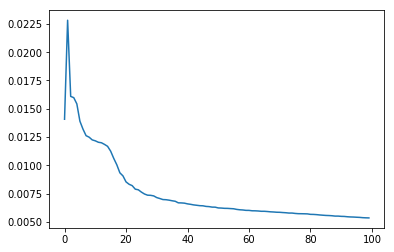

In [108]:
plt.plot(svd_mini.explained_variance_)

#### Analysis of SVD and hyperparameter search

Because of the processing time necessary for preprocessing steps, we'll try to identify optimal values of hyperparameters by using smaller subsets of the the training data. We'll use a sampling method to randomly select (without replacement) from the training set to obtain samples that range in size from 4%-12% of the total data size, just to make sure the size of the samples doesn't impact the dimensionality reduction significantly.

In [27]:
def svd_comp_analysis(cv_train_subset, n_comp, plotting=True, printout=False):

    t0 = time.time()
    
    analysis = {}
    params_svd = {'n_components': range(1,n_comp+1)}
    for i, n in enumerate(params_svd['n_components']):
        
        config_n = i
        config_params = {}
        
        message0 = "SVD n_components: {}".format(n)
        if printout == True:
            print(message0)
    
        # Apply SVD transformation
        t1 = time.time()
        message3 = "\tBeginning svd component: {}".format(n)
        
        if printout == True:
            print(message3, end="\r")
            
        svd = TruncatedSVD(n_components=n, algorithm='arpack')
        svd.fit_transform(cv_train_subset)
        config_params["explained_variance_ratio"] = svd.explained_variance_ratio_
              
        if printout == True:
            print(print_blank(len(message3)), end="\r")
        message4 = "\tSVD done in {:.2f} seconds".format(time.time() - t1)
              
        evar = svd_metrics(svd, n)
        config_params["explained_variance"] = evar
              
        analysis[config_n] = config_params
        if printout == True:
            print("\t{} components completed in: {:.2f} seconds".format(n, time.time()-t1))
        message5 = "{} components in {:.2f}(iter)/{:.2f}(total) secs".format(n, time.time()-t1, time.time()-t0)
        message6 = "{} {}".format(message5, ". "*n)
        print(message6, end="\r")
    
    print(print_blank(len(message6)), end="\r")
    print("\nTotal time to completion for {} components: {:.2f} seconds".format(n_comp, time.time()-t0))
    
    return analysis

In [28]:
def svd_batch_analysis(n_epoch=1, n_comp=20, plotting=True):
    t0 = time.time()
    
    if plotting == True:
        fig, ax = plt.subplots()
    
    batch = {}
    epochs = {'n_epoch': range(1,n_epoch+1)}
    for i, n in enumerate(epochs['n_epoch']):
        
        t1 = time.time()
        message0 = "Epoch: {}".format(n)
        print(message0, end="\r")
    
        comp_results = {}
        # create subset with `p_data` percent of training data in range(4,12)
        p_data = np.random.randint(4, 12)/100
        comp_results["p_data"] = p_data
        
        # Create mini data sets for model building
        train_subset = train.sample(frac=p_data)
        y_train_subset = train_subset['Class'].values
        X_train_subset = train_subset.drop('Class', axis=1)

        # Create mini dev set for model building
        dev_subset = train.sample(frac=p_data)
        y_dev_subset = dev_subset['Class'].values
        X_dev_subset = dev_subset.drop('Class', axis=1)
        
        corpus_train_subset = X_train_subset['Text']
        corpus_dev_subset = X_dev_subset['Text']

        comp_results["x_shape"] = X_train_subset.shape
    
        # Apply tokenization
        print(print_blank(len(message0)), end="\r")
        message1 = "Epoch: {} Applying tokenization...".format(n)
        print(message1, end="\r")
              
        cv = CountVectorizer(preprocessor=lambda x: text_preprocessor(x, action=[0, 2, 3]), 
                     lowercase=True, 
                     stop_words='english', 
                     min_df=1, 
                     max_df=.1, 
                     ngram_range=(1,2))
        comp_results["count_vectorizer"] = cv
        
        cv_train_subset = cv.fit_transform(corpus_train_subset)
        #cv_dev_subset = cv.transform(corpus_dev_subset)
              
        print(print_blank(len(message1)), end="\r")
        message2 = "\tTokenization done in {:.2f} seconds".format(time.time() - t0)
        print(message2, end="\r")
        
        # Number of components must be less than number of observations
        if X_train_subset.shape[0] < n_comp:
            n_comp = X_train_subset.shape[0]-1
            
        batch_analysis = svd_comp_analysis(cv_train_subset, n_comp, plotting)
        comp_results["results"] = batch_analysis
        batch[i] = comp_results
        
        if plotting == True:
            ax.plot(batch[i]['results'][n_comp-1]['explained_variance_ratio'])
        
        print(print_blank(len(message2)), end="\r")
        print("Epoch {} completed in: {:.2f} seconds".format(n, time.time()-t1))
    
    print("\nTotal time to completion for {} epochs: {:.2f} seconds".format(n_epoch, time.time()-t0))
    
    return batch

None                                                                                                                                                                                       
Total time to completion for 70 components: 242.61 seconds
Epoch 1 completed in: 340.64 seconds
None                                                                                                                                                                                      
Total time to completion for 70 components: 60.97 seconds
Epoch 2 completed in: 95.63 seconds 

Total time to completion for 2 epochs: 436.37 seconds


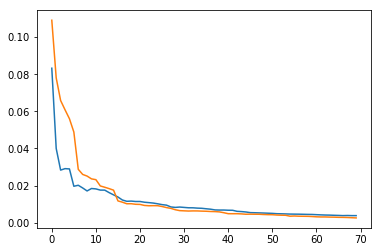

In [54]:
svd_comp0 = svd_batch_analysis(2, 70, plotting=True)

None                                                                                                                                                                                       
Total time to completion for 70 components: 312.05 seconds
Epoch 1 completed in: 413.75 seconds
None                                                                                                                                                                                       
Total time to completion for 70 components: 270.86 seconds
Epoch 2 completed in: 371.01 seconds
None                                                                                                                                                                                       
Total time to completion for 70 components: 183.55 seconds
Epoch 3 completed in: 253.86 seconds
None                                                                                                                                                

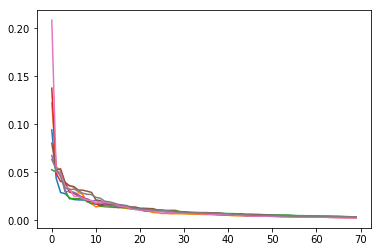

In [63]:
svd_comp1 = svd_batch_analysis(8, 70, plotting=True)

(10, 60)

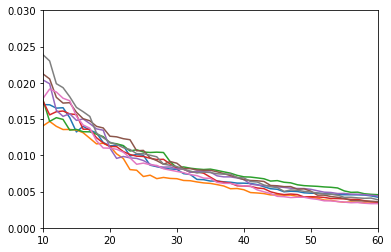

In [90]:
fig, ax = plt.subplots()
for i in range(len(svd_comp1)):
    ax.plot(svd_comp1[i]['results'][len(svd_comp1[i]['results'])-1]['explained_variance_ratio'])
plt.ylim([0, 0.03])
plt.xlim([10,60])

In [82]:
p_frac_comp1 = [svd_comp1[i]['p_data'] for i in range(len(svd_comp1))]
print(p_frac_comp1)
print(np.mean(p_frac_comp1))

[0.11, 0.1, 0.08, 0.09, 0.09, 0.05, 0.05, 0.06]
0.07875


##### Sanity check performing same analysis on TF-IDF Vectorizer transformation

In [29]:
def svd2_batch_analysis(n_epoch=1, n_comp=20, plotting=True):
    t0 = time.time()
    
    if plotting == True:
        fig, ax = plt.subplots()
    
    batch = {}
    epochs = {'n_epoch': range(1,n_epoch+1)}
    for i, n in enumerate(epochs['n_epoch']):
        
        t1 = time.time()
        message0 = "Epoch: {}".format(n)
        print(message0, end="\r")
    
        comp_results = {}
        # create subset with `p_data` percent of training data in range(4,12)
        p_data = np.random.randint(4, 12)/100
        comp_results["p_data"] = p_data
        
        # Create mini data sets for model building
        train_subset = train.sample(frac=p_data)
        y_train_subset = train_subset['Class'].values
        X_train_subset = train_subset.drop('Class', axis=1)

        # Create mini dev set for model building
        dev_subset = train.sample(frac=p_data)
        y_dev_subset = dev_subset['Class'].values
        X_dev_subset = dev_subset.drop('Class', axis=1)
        
        corpus_train_subset = X_train_subset['Text']
        corpus_dev_subset = X_dev_subset['Text']

        comp_results["x_shape"] = X_train_subset.shape
    
        # 2. Apply tokenization
        print(print_blank(len(message0)), end="\r")
        message1 = "Epoch: {} Applying tokenization...".format(n)
        print(message1, end="\r")
        
        tf, tf_train_subset, tf_dev_subset = tfidf_fn(corpus_train_subset, 
                                                corpus_dev_subset, 
                                                ngrams=2, 
                                                mn=1, 
                                                mx=0.1, 
                                                test_transform=True, 
                                                plotting=False)
              
        comp_results["tfidf_vectorizer"] = tf_subset
        
        tf_train_subset = cv.fit_transform(corpus_train_subset)
        #cv_dev_subset = cv.transform(corpus_dev_subset)
              
        print(print_blank(len(message1)), end="\r")
        message2 = "\tTokenization done in {:.2f} seconds".format(time.time() - t0)
        print(message2, end="\r")
        
        # Number of components must be less than number of observations
        if X_train_subset.shape[0] < n_comp:
            n_comp = X_train_subset.shape[0]-1
            
        batch_analysis = svd_comp_analysis(tf_train_subset, n_comp, plotting)
        comp_results["results"] = batch_analysis
        batch[i] = comp_results
        
        if plotting == True:
            ax.plot(batch[i]['results'][n_comp-1]['explained_variance_ratio'])
        
        print(print_blank(len(message2)), end="\r")
        print("Epoch {} completed in: {:.2f} seconds".format(n, time.time()-t1))
    
    print("\nTotal time to completion for {} epochs: {:.2f} seconds".format(n_epoch, time.time()-t0))
    
    return batch

None                                                                                                                                                                                       
Total time to completion for 70 components: 315.89 seconds
Epoch 1 completed in: 433.12 seconds
None                                                                                                                                                                                       
Total time to completion for 70 components: 109.92 seconds
Epoch 2 completed in: 163.44 seconds
None                                                                                                                                                                                       
Total time to completion for 70 components: 143.72 seconds
Epoch 3 completed in: 207.37 seconds
None                                                                                                                                                

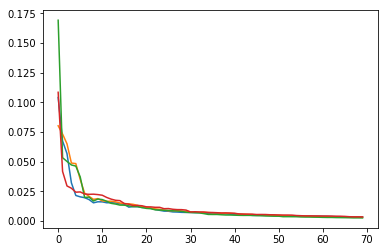

In [93]:
tf_comp0 = svd_batch_analysis(4, 70, plotting=True)

(10, 60)

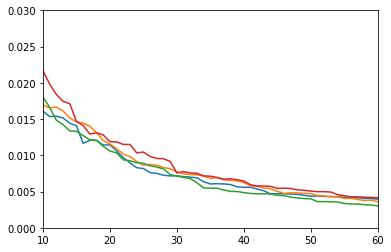

In [94]:
fig, ax = plt.subplots()
for i in range(len(tf_comp0)):
    ax.plot(tf_comp0[i]['results'][len(tf_comp0[i]['results'])-1]['explained_variance_ratio'])
plt.ylim([0, 0.03])
plt.xlim([10,60])

##### Number of SVD Components

From the figure, we can see that as we add components, we start to see a diminishing return on explained variance, and start to add significant computation time. We varied the batch size to be just around 8% of the total training set, and since it looks like the explained variance starts to stabilize somewhere between around 20 and 40 components, we might consider scaling that by about 10x for the full dataset. This would give us about 200 components, which isn't exactly a precise measurement, but it coincides with general guidance on using SVD from external [resources](http://www.kdnuggets.com/2016/08/approaching-almost-any-machine-learning-problem.html/2) and gives us an estimate to work with.

### Full data set

In [34]:
tfidf, tfidf_train, tfidf_test = tfidf_fn(corpus_train,
                                corpus_test,
                                ngrams=2, 
                                mn=1, 
                                mx=0.1, 
                                test_transform=True, 
                                plotting=False)

Shape: (3321, 2690998)                     s
Non-zero mean: 4586
Non-zero median: 3328

Done in 2075.80 seconds


In [53]:
type(tfidf)

sklearn.feature_extraction.text.TfidfVectorizer

Save tokenized vocabulary

In [31]:
def save_sparse_csr(filename,array):
    np.savez(filename,data = array.data ,indices=array.indices,
             indptr =array.indptr, shape=array.shape )

In [34]:
def load_sparse_csr(filename):
    loader = np.load(filename + '.npz')
    return sps.csr_matrix((  loader['data'], loader['indices'], loader['indptr']),
                         shape = loader['shape'])

In [51]:
save_sparse_csr(data_directory + '/data/train_bigram_vocabulary', tfidf_train)

CPU times: user 406 ms, sys: 599 ms, total: 1.01 s
Wall time: 1.23 s


In [52]:
save_sparse_csr(data_directory + '/data/test_bigram_vocabulary', tfidf_test)

CPU times: user 587 ms, sys: 797 ms, total: 1.38 s
Wall time: 1.63 s


Load tfidf from previous session if applicable:

In [35]:
%%time 
tfidf = TfidfVectorizer()
tfidf_train = load_sparse_csr(data_directory + '/data/train_bigram_vocabulary')
tfidf_test = load_sparse_csr(data_directory + '/data/test_bigram_vocabulary')

CPU times: user 911 ms, sys: 345 ms, total: 1.26 s
Wall time: 1.31 s


In order to reduce the dimensionality of the transformed text, we can use truncated singular value decomposition (SVD), which is similar to PCA, but for sparse matrices. 

In [36]:
# Choose index of number of features where we will truncate dimensionality
features_n_svd = 200

Load previously transformed data if applicable.

In [ ]:
np.load(data_directory + '/data/train_svd_200')
np.load(data_directory + '/data/test_svd_200')

In [37]:
%%time
svd = TruncatedSVD(features_n_svd, algorithm='arpack')
svd_train = svd.fit_transform(tfidf_train)
svd_test = svd.transform(tfidf_test)

In [38]:
svd_train.shape

(3321, 200)

In [45]:
np.save(data_directory + '/data/train_svd_200', svd_train)
np.save(data_directory + '/data/test_svd_200', svd_test)

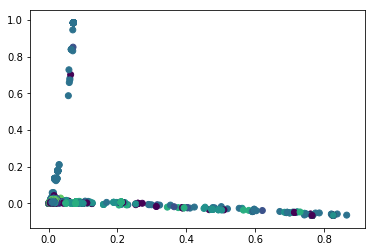

In [39]:
data2D_svd = svd_train
plt.scatter(data2D_svd[:,0], data2D_svd[:,1], c=y_train)
plt.show()  

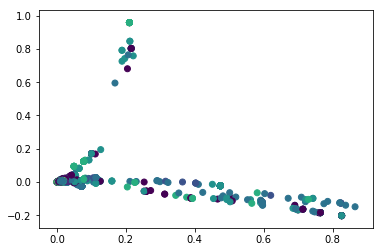

In [40]:
data2D_svd = svd_train
plt.scatter(data2D_svd[:,0], data2D_svd[:,2], c=y_train)
plt.show() 

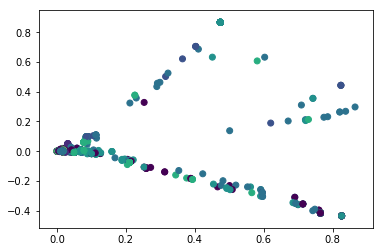

In [41]:
data2D_svd = svd_train
plt.scatter(data2D_svd[:,0], data2D_svd[:,3], c=y_train)
plt.show() 